In [1]:
import openai
from pathlib import Path
import json
import llm2geneset
import time
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("genes_overlap.tsv", sep="\t")

In [3]:
df.head()

,database,model,descr,ncurated,nllm,ninter,generatio,bgratio,non_hgcn,ndup,p_val,p_val_adj
0,KEGG_2021_Human,gpt-3.5-turbo-0125,ABC transporters,45,7,5,0.714286,0.002267,0,0,1.008570e-12,3.227424e-10
1,KEGG_2021_Human,gpt-3.5-turbo-0125,AGE-RAGE signaling pathway in diabetic complic...,100,41,20,0.487805,0.005039,1,5,4.022773e-36,1.287287e-33
2,KEGG_2021_Human,gpt-3.5-turbo-0125,AMPK signaling pathway,120,10,8,0.800000,0.006047,1,0,6.592581e-17,2.109626e-14
3,KEGG_2021_Human,gpt-3.5-turbo-0125,Acute myeloid leukemia,67,8,4,0.500000,0.003376,0,0,8.330898e-09,2.665887e-06
4,KEGG_2021_Human,gpt-3.5-turbo-0125,Adherens junction,71,5,4,0.800000,0.003578,0,0,7.606261e-10,2.434003e-07


In [4]:
depth_root_dir = "libs_human/go_depth"

In [5]:
go_db=['GO_Cellular_Component_2023', 'GO_Cellular_Component_2023','GO_Cellular_Component_2023']

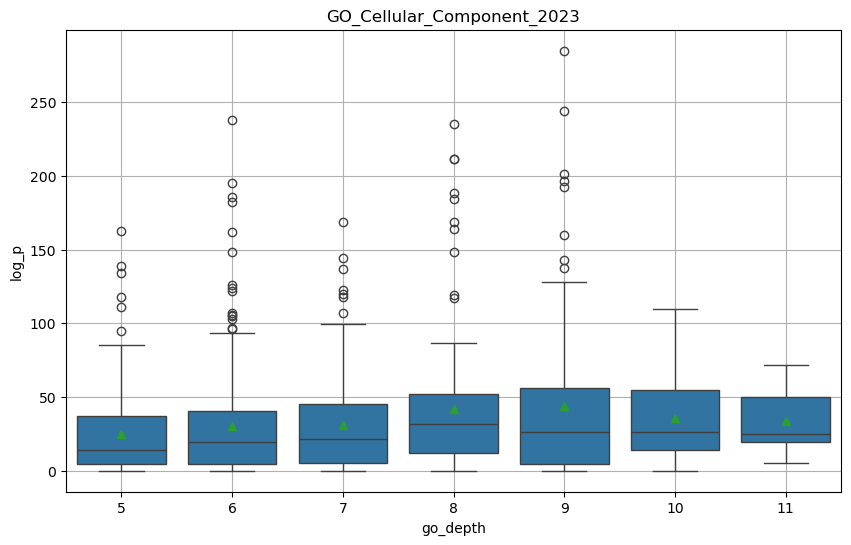

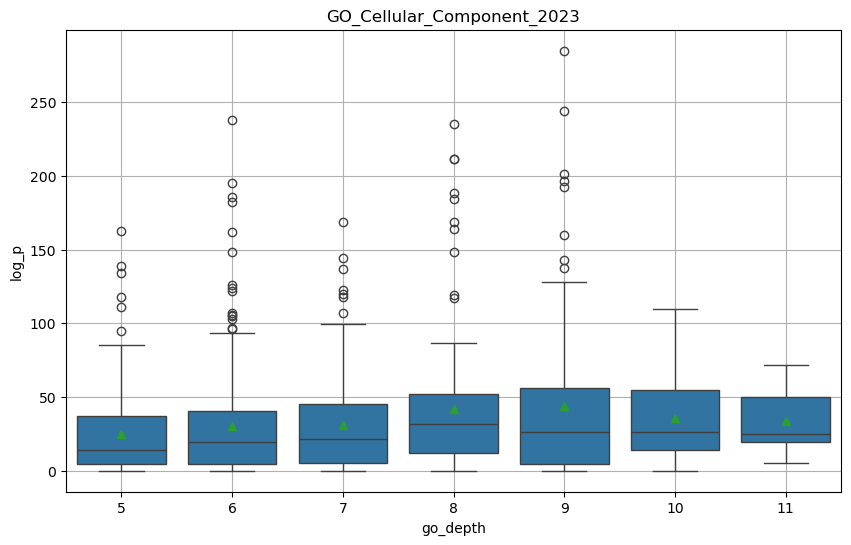

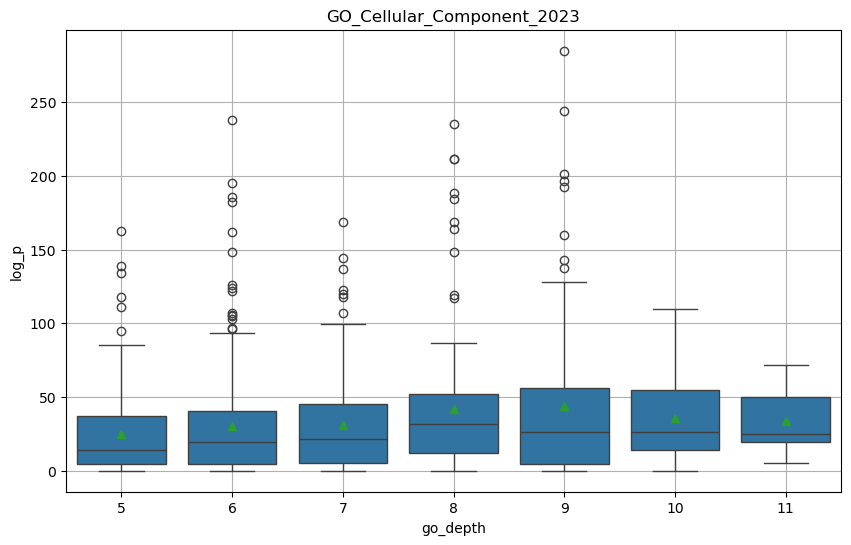

In [6]:
pattern = r'\(GO:\d+\)'

for db in go_db:
    path=os.path.join(depth_root_dir,db+'.txt')
    df_depth = pd.read_csv(path, sep="\t")
    df_sub = df[df.database==db]
    
    cleaned_term=[]
    for i in df_depth.term.values:
        cleaned_term.append(re.sub(pattern, '', i).strip())
    df_depth['descr']=cleaned_term
    df_merge = df_depth.merge(df_sub, on='descr')
    if len(df_merge)!= len(df_sub):
        print("merged dataframe has different size")
    df_merge['log_p']=-np.log(df_merge['p_val'])
    
    # Create a box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='go_depth', y='log_p', data=df_merge, showmeans=True)
    
    # Add labels and title
    plt.xlabel('go_depth')
    plt.ylabel('log_p')
    plt.title(db)
    
    # Show plot
    plt.grid(True)
    plt.show()


# Count significant gene sets per GO-depth

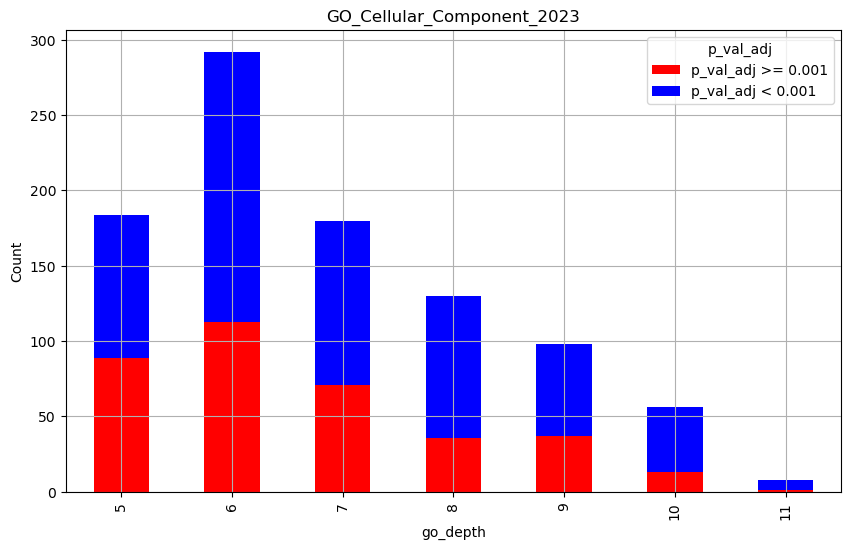

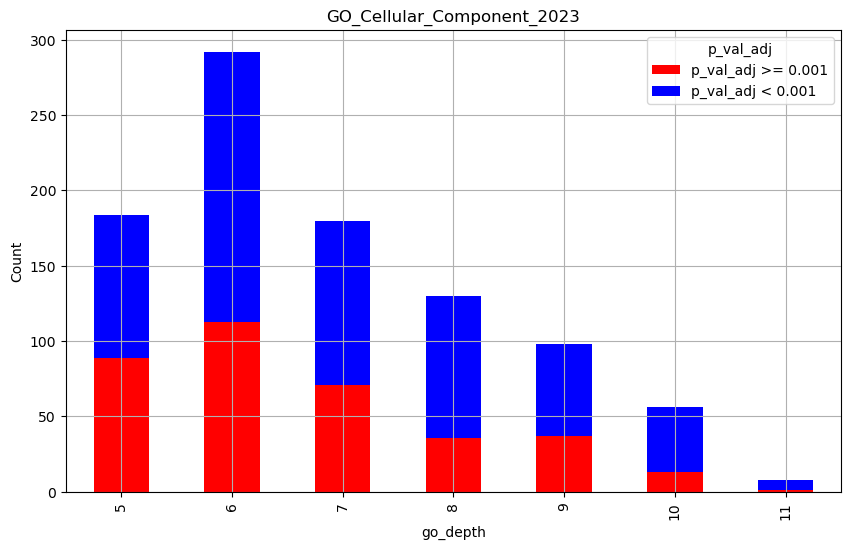

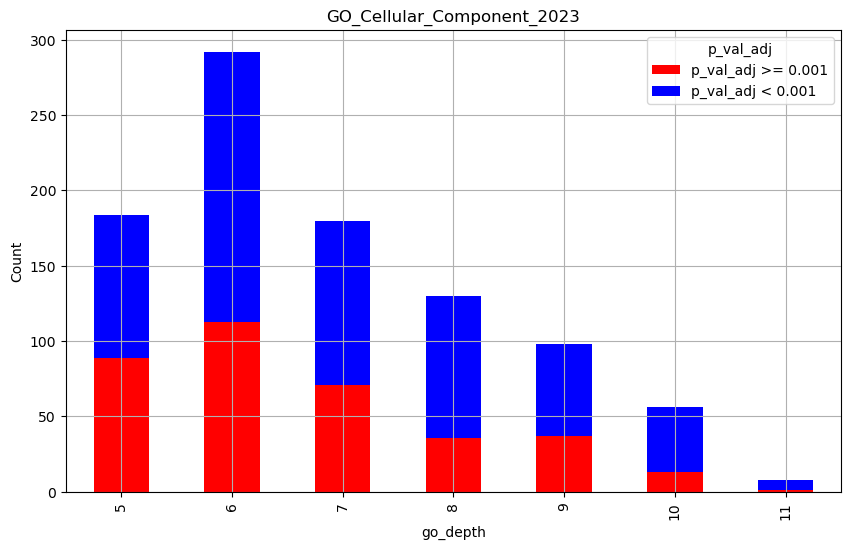

In [9]:
pattern = r'\(GO:\d+\)'

for db in go_db:
    path=os.path.join(depth_root_dir,db+'.txt')
    df_depth = pd.read_csv(path, sep="\t")
    df_sub = df[df.database==db]
    
    cleaned_term=[]
    for i in df_depth.term.values:
        cleaned_term.append(re.sub(pattern, '', i).strip())
    df_depth['descr']=cleaned_term
    df_merge = df_depth.merge(df_sub, on='descr')
    if len(df_merge)!= len(df_sub):
        print("merged dataframe has different size")
    df_merge['log_p']=-np.log(df_merge['p_val'])

    # Prepare the data for the bar plot
    cutoff=0.001
    df_merge['p_val_adj_category'] = df_merge['p_val_adj'] < cutoff
    
    # Count the occurrences of each go_depth and p_val_adj_category
    count_data = df_merge.groupby(['go_depth', 'p_val_adj_category']).size().reset_index(name='count')
    
    # Pivot the data for better visualization
    count_data_pivot = count_data.pivot(index='go_depth', columns='p_val_adj_category', values='count').fillna(0)
    count_data_pivot.columns = [f'p_val_adj >= {cutoff}', f'p_val_adj < {cutoff}']
    
    # Plot the bar plot
    count_data_pivot.plot(kind='bar', stacked=True, color=['red', 'blue'], figsize=(10, 6))
    
    # Add labels and title
    plt.xlabel('go_depth')
    plt.ylabel('Count')
    plt.title(db)
    
    # Show plot
    plt.grid(True)
    plt.legend(title='p_val_adj')
    plt.show()

# Fraction of significant gene sets per GO-depth

In [10]:
pattern = r'\(GO:\d+\)'

for db in go_db:
    path=os.path.join(depth_root_dir,db+'.txt')
    df_depth = pd.read_csv(path, sep="\t")
    df_sub = df[df.database==db]
    
    cleaned_term=[]
    for i in df_depth.term.values:
        cleaned_term.append(re.sub(pattern, '', i).strip())
    df_depth['descr']=cleaned_term
    df_merge = df_depth.merge(df_sub, on='descr')
    if len(df_merge)!= len(df_sub):
        print("merged dataframe has different size")
    df_merge['log_p']=-np.log(df_merge['p_val'])

    # Prepare the data for the bar plot
    df_merge['p_val_adj_category'] = df_merge['p_val_adj'] < 0.01
        cutoff=0.001
    df_merge['p_val_adj_category'] = df_merge['p_val_adj'] < cutoff
    # Count the occurrences of each go_depth and p_val_adj_category
    count_data = df_merge.groupby(['go_depth', 'p_val_adj_category']).size().reset_index(name='count')
    
    # Pivot the data for better visualization
    count_data_pivot = count_data.pivot(index='go_depth', columns='p_val_adj_category', values='count').fillna(0)
    count_data_pivot.columns = ['p_val_adj >= 0.01', 'p_val_adj < 0.01']
    
    # Calculate the fractions
    count_data_pivot['total'] = count_data_pivot.sum(axis=1)
    count_data_pivot['fraction < 0.01'] = count_data_pivot['p_val_adj < 0.01'] / count_data_pivot['total']
    count_data_pivot['fraction >= 0.01'] = count_data_pivot['p_val_adj >= 0.01'] / count_data_pivot['total']
    
    # Plot the bar plot
    plt.figure(figsize=(10, 6))
    count_data_pivot[['fraction >= 0.01', 'fraction < 0.01']].plot(kind='bar', stacked=True, color=['red', 'blue'], ax=plt.gca())
    
    # Add labels and title
    plt.xlabel('go_depth')
    plt.ylabel('Fraction')
    plt.title(db)
    plt.legend(title='p_val_adj')
    
    # Show plot
    plt.grid(True)
    plt.show()

KeyError: 'p_val_adj < 0.01'

In [9]:
df_merge.columns

Index(['term', 'go_id', 'go_depth', 'descr', 'database', 'model', 'ncurated',
       'nllm', 'ninter', 'generatio', 'bgratio', 'non_hgcn', 'ndup', 'p_val',
       'p_val_adj', 'log_p', 'p_val_adj_category'],
      dtype='object')

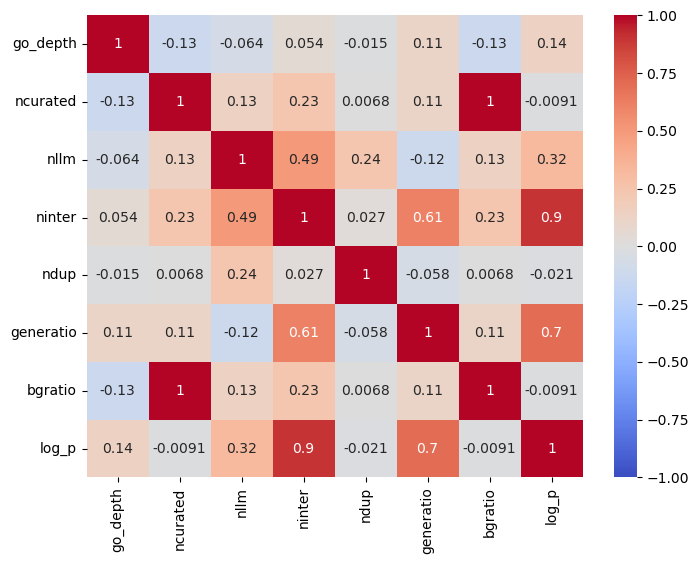

In [10]:
# Extract the columns of interest
df_heatmap = df_merge[['go_depth', 'ncurated', 'nllm', 'ninter','ndup', 'generatio','bgratio','log_p']]

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_heatmap.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

# Show the fraction significant.